![](./resources/Default_cropland_map.png)

In [36]:
from worldcereal.utils.map import ui_map

# Setting area limit to 2500 km²
map = ui_map(area_limit=100000)

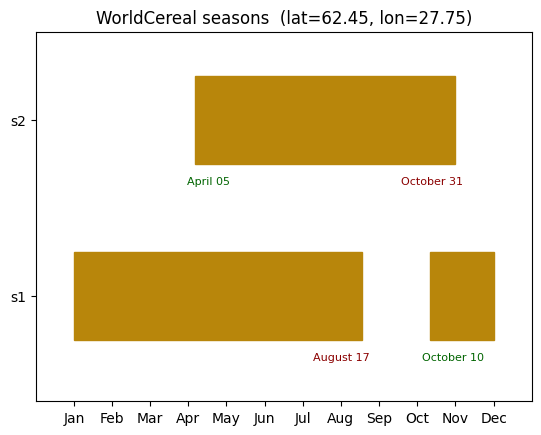

In [37]:
from notebook_utils.seasons import retrieve_worldcereal_seasons

spatial_extent = map.get_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Execute the next cell and drag the slider to select your processing period:

In [38]:
from notebook_utils.dateslider import date_slider
slider = date_slider()

In [39]:
from openeo.extra.job_management._job_splitting import split_area
import geopandas as gpd

processing_period = slider.get_processing_period()
processing_extent = map.get_extent()



2025-06-03 19:49:00.747 | INFO     | notebook_utils.dateslider:get_processing_period:187 - Selected processing period: 2018-01-01 to 2018-12-31


Option 1; use a job manager for tile splitting and managing multiple jobs to support a larger extend. As a default we make use of 20 by 20 km tilings. 

Downsides: 
- need a higher openEO version

Upside:
- a lot of control over the individual jobs through the job manager

In [ ]:
import openeo
from openeo.extra.job_management import (
        ProcessBasedJobCreator,
        CsvJobDatabase,
        MultiBackendJobManager
    )
from openeo.extra.job_management._job_splitting import split_area
import geopandas as gpd
#had to upgrade to openeo 0.42 to use the job_splitting functionality

bbox = {
    "west": processing_extent.west,
    "south": processing_extent.south,
    "east": processing_extent.east,
    "north": processing_extent.north,
    "crs": f"EPSG:{processing_extent.epsg}"
}

grid_gdf = gpd.GeoDataFrame({'geometry': split_area(bbox)}, crs=f"EPSG:{processing_extent.epsg}")

grid_gdf["temporal_extent"] = [[processing_period.start_date, processing_period.end_date]] * len(grid_gdf)

latlon_geom = grid_gdf.geometry.to_crs(epsg=4326)
grid_gdf["spatial_extent"] = latlon_geom.bounds.apply(
    lambda row: {
        "west": float(row.minx),
        "south": float(row.miny),
        "east": float(row.maxx),
        "north": float(row.maxy)
    }, axis=1
)

grid_gdf

#
process_graph_url = "https://raw.githubusercontent.com/WorldCereal/worldcereal-classification/refs/tags/worldcereal_crop_type_v1.1.0/src/worldcereal/udp/worldcereal_crop_type.json"

start_job = ProcessBasedJobCreator(
        namespace=process_graph_url,
        parameter_defaults={"model_url": "https://s3.waw3-1.cloudferro.com/swift/v1/APEx-benchmarks/worldcereal_crop_type/test_worldcereal_crop_type_custommodel.onnx"},
    )


# Initiate MultiBackendJobManager 
job_manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
job_manager.add_backend("cdse", connection=connection, parallel_jobs=10)


job_db = CsvJobDatabase(path='jobs.csv')
job_manager.run_jobs(df=grid_gdf, start_job=start_job, job_db=job_db)



Authenticated using refresh token.


Option 2: 

Use the aggregator of the federated backend to enforce automated tile splitting. 

Requires an update to the UDP to include an additional job option

Downside:
- little control and vision on the running jobs

In [29]:
import requests
connection = openeo.connect("https://openeofed.dataspace.copernicus.eu/").authenticate_oidc()

process_graph_url = "https://gist.githubusercontent.com/HansVRP/8a9dc0fb5a213fc883dd6fff1a02b333/raw/30cce8f452e48a9ab791bcc5dcf81d38da78fdd5/worldcereal_crop_type.json"

spatial_extent = {
    "west": processing_extent.west,
    "south": processing_extent.south,
    "east": processing_extent.east,
    "north": processing_extent.north,
    "crs": f"EPSG:{processing_extent.epsg}"
}

temporal_extent = [processing_period.start_date, processing_period.end_date]


# Define the temporal extent

datacube = connection.datacube_from_json(process_graph_url,
                                        parameters = {'spatial_extent': spatial_extent,
                                                    'temporal_extent': temporal_extent,
                                                    'model_url': "https://s3.waw3-1.cloudferro.com/swift/v1/APEx-benchmarks/worldcereal_crop_type/test_worldcereal_crop_type_custommodel.onnx"})
datacube
job = datacube.create_job(title="test")
job
#job

#job.start_and_wait()



Authenticated using refresh token.


Preflight process graph validation raised: [UpstreamValidationFailure] Validation failed on backend cdse: OpenEoApiPlainError('[403] {"status":"error","data":{"message":"This request was rejected due to a violation. Please consult with your administrator, and provide this reference ID:  4072137436706522281"}}')


OpenEoApiError: [500] Internal: Failed to create job on backend 'cdse': OpenEoApiPlainError('[403] {"status":"error","data":{"message":"This request was rejected due to a violation. Please consult with your administrator, and provide this reference ID:  4072137436705104318"}}') (ref: r-2506031544044a0bbcbf4d0aebd61cc2)